In [79]:
import os
import gc
import optuna
import warnings
import numpy as np
from utils import *
import pandas as pd
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
warnings.filterwarnings('ignore')
%run skills.ipynb
%run languages.ipynb
%run work_experiences.ipynb
%run education.ipynb

class config:
    train_path = '../../../datasets/garanti-bbva-data-camp/train_users.csv'
    test_path = '../../../datasets/garanti-bbva-data-camp/test_users.csv'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/skills.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/languages.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/education.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'
    seed = 42
    n_folds = 6

In [80]:
train_df = pd.read_csv(config.train_path)
test_df = pd.read_csv(config.test_path)
sub = pd.read_csv(config.sub_path)

print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')
df = train_df.append(test_df).reset_index(drop = True)
df.head()

train_df shape: (53019, 4)
test_df shape: (13255, 3)


,user_id,industry,location,moved_after_2019
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1.0
1,6950,Internet,"Istanbul, Istanbul, Turkey",0.0
2,4880,Online Media,Turkey,0.0
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0.0
4,11005,Banking,"Istanbul, Turkey",0.0


In [81]:
def fix_location(dataframe: pd.DataFrame) -> pd.DataFrame:

    df_ = dataframe.copy()
    df_.loc[df_['location'].astype(str).str.contains('Kahraman Maras'), 'location'] = 'Kahramanmaras, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Şanliurfa'), 'location'] = 'Sanliurfa, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('İçel'), 'location'] = 'Mersin, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Afyon'), 'location'] = 'Afyonkarahisar, Turkey'
    df_['location'] = df_['location'].apply(lambda x: str(x).replace('Türkiye', 'Turkey'))
    df_['location'] = df_['location'].apply(lambda x: x.upper().strip())
    df_['location'] = df_['location'].apply(lambda x: translation(str(x)))
    tr_cities = load_tr_cities()
    for city in tr_cities:
        df_['location'] = df_['location'].apply(lambda x: city if city in x else x)
        df_['based_on_tr'] = df_['location'].apply(lambda x: 1 if x in tr_cities or x == 'TURKEY' else 0)

    return df_

df = fix_location(df)

In [82]:
skills_df = load_skills(config.skills_path, 60)
lang_df = load_languages(config.languages_path, 10)
edu_df = load_education(config.education_path, 21, 15)
exp_df = load_work_experiences(config.exp_path)

df = df.merge(skills_df, on = ['user_id'], how = 'left')
df = df.merge(lang_df, on = ['user_id'], how = 'left')
df = df.merge(edu_df, on = ['user_id'], how = 'left')
df = df.merge(exp_df, on = ['user_id'], how = 'left')

df['nunique_company_by_industries'] = df.groupby(by = 'industry')['company_id'].transform('nunique')

#df['employee_total_last_exp_diff'] = df['employee_total_experience'] - df['employee_last_experience']

#df['nunique_employees_by_industries'] = df.groupby(by = 'industry')['user_id'].transform('nunique')

print(df.shape)
df.head()

Frequency of top 20 skills before preprocess: 294433
Frequency of top 20 skills after preprocess: 320842


100%|██████████| 15/15 [00:03<00:00,  4.34it/s]


(66274, 130)


,user_id,industry,location,moved_after_2019,based_on_tr,skill_Java,skill_JavaScript,skill_C#,skill_SQL,skill_Software Development,...,employee_last_experience_year,nunique_company,employee_avg_days_to_quit,employee_last_quit,company_id,company_avg_days_to_quit,company_std_days_to_quit,company_max_days_to_quit,company_med_days_to_quit,nunique_company_by_industries
0,1301,Information Technology and Services,ISTANBUL,1.0,1,1.0,0.0,0.0,0.0,1.0,...,2018.0,3.0,447.000000,882.0,26.0,912.280537,808.719538,5206.0,701.0,3260.0
1,6950,Internet,ISTANBUL,0.0,1,1.0,1.0,1.0,1.0,1.0,...,2017.0,4.0,525.250000,184.0,1337.0,393.769231,376.905194,1155.0,184.0,743.0
2,4880,Online Media,TURKEY,0.0,1,0.0,1.0,1.0,1.0,0.0,...,2017.0,4.0,456.500000,273.0,4366.0,NaN,NaN,NaN,NaN,32.0
3,26046,Telecommunications,ISTANBUL,0.0,1,0.0,0.0,0.0,0.0,0.0,...,2014.0,1.0,3409.000000,NaN,26.0,912.280537,808.719538,5206.0,701.0,660.0
4,11005,Banking,ISTANBUL,0.0,1,0.0,0.0,1.0,0.0,0.0,...,2017.0,3.0,1136.333333,2435.0,1562.0,837.166667,767.031502,3957.0,609.0,424.0


In [83]:
from kmodes.kmodes import KModes

cluster = KModes(n_clusters=6, n_jobs=-1)

df['kmodes_label'] = cluster.fit_predict(df[[col for col in df.columns if 
                        col.startswith('skill') or
                        col.startswith('degree') or
                        col.startswith('study') or
                        col.startswith('language')]].fillna(0))



In [84]:
target = 'moved_after_2019'
cat_features = ['industry', 'location', 'company_id', 'kmodes_label', 'employee_last_experience_year', 'employee_last_experience_month']
drop_features = ['user_id']

for caterogical_col in cat_features:
    df[caterogical_col] = df[caterogical_col].astype(str).astype("category")

train_set = df.loc[df[target].notnull()].drop(columns=drop_features, axis = 1)
test_set = df.loc[df[target].isnull()].drop(columns=drop_features, axis = 1)

print(f'train_set: {train_set.shape}')
print(f'test_set: {test_set.shape}')

train_set: (53019, 130)
test_set: (13255, 130)


In [87]:
# CatBoost Parameters
#params = {'one_hot_max_size': 179,
#          'depth': 12,
#          'boosting_type': 'Plain',
#          'bootstrap_type': 'MVS',
#          #'bagging_temperature': 0.2
#          }

params = {'one_hot_max_size': 180,
          'depth': 12,
          'boosting_type': 'Plain',
          'bootstrap_type': 'MVS'}

params["iterations"] = 4000
params['random_state'] = config.seed
params['cat_features'] = cat_features
params['eval_metric'] = 'Accuracy'
params['allow_writing_files'] = False
params['verbose'] = False

## XGB Parameters
#params = {'max_depth': 10,
#          'subsample': 0.8,
#          'eta': 0.02,
#          'reg_alpha': 2,
#          'reg_lambda': 24,
#          'learning_rate': 0.01}
#
##params['eval_metric'] = 'Accuracy'
#params['random_state'] = config.seed
#params['tree_method'] = 'hist'
#params['n_estimators'] = 5000
#params['enable_categorical'] = True

kf = KFold(n_splits=config.n_folds, shuffle=True, random_state=config.seed)
#kf = KFold(n_splits=config.n_folds)

-----------------------------------| Fold 1 |-----------------------------------
Learning rate set to 0.044197
0:	learn: 0.6371826	test: 0.6263438	best: 0.6263438 (0)	total: 42.4ms	remaining: 2m 49s
200:	learn: 0.8687701	test: 0.7507073	best: 0.7507073 (200)	total: 40s	remaining: 12m 35s
400:	learn: 0.9248110	test: 0.7629286	best: 0.7633812 (386)	total: 1m 19s	remaining: 11m 51s
600:	learn: 0.9509302	test: 0.7693787	best: 0.7705104 (559)	total: 1m 59s	remaining: 11m 13s
800:	learn: 0.9662985	test: 0.7746973	best: 0.7756026 (764)	total: 2m 38s	remaining: 10m 34s
1000:	learn: 0.9767779	test: 0.7785448	best: 0.7797895 (989)	total: 3m 19s	remaining: 9m 56s
1200:	learn: 0.9827079	test: 0.7806948	best: 0.7808080 (1199)	total: 3m 59s	remaining: 9m 19s
1400:	learn: 0.9870083	test: 0.7808080	best: 0.7813738 (1338)	total: 4m 40s	remaining: 8m 41s
1600:	learn: 0.9894527	test: 0.7825054	best: 0.7829580 (1597)	total: 5m 20s	remaining: 7m 59s
1800:	learn: 0.9911955	test: 0.7818264	best: 0.7832975 (1

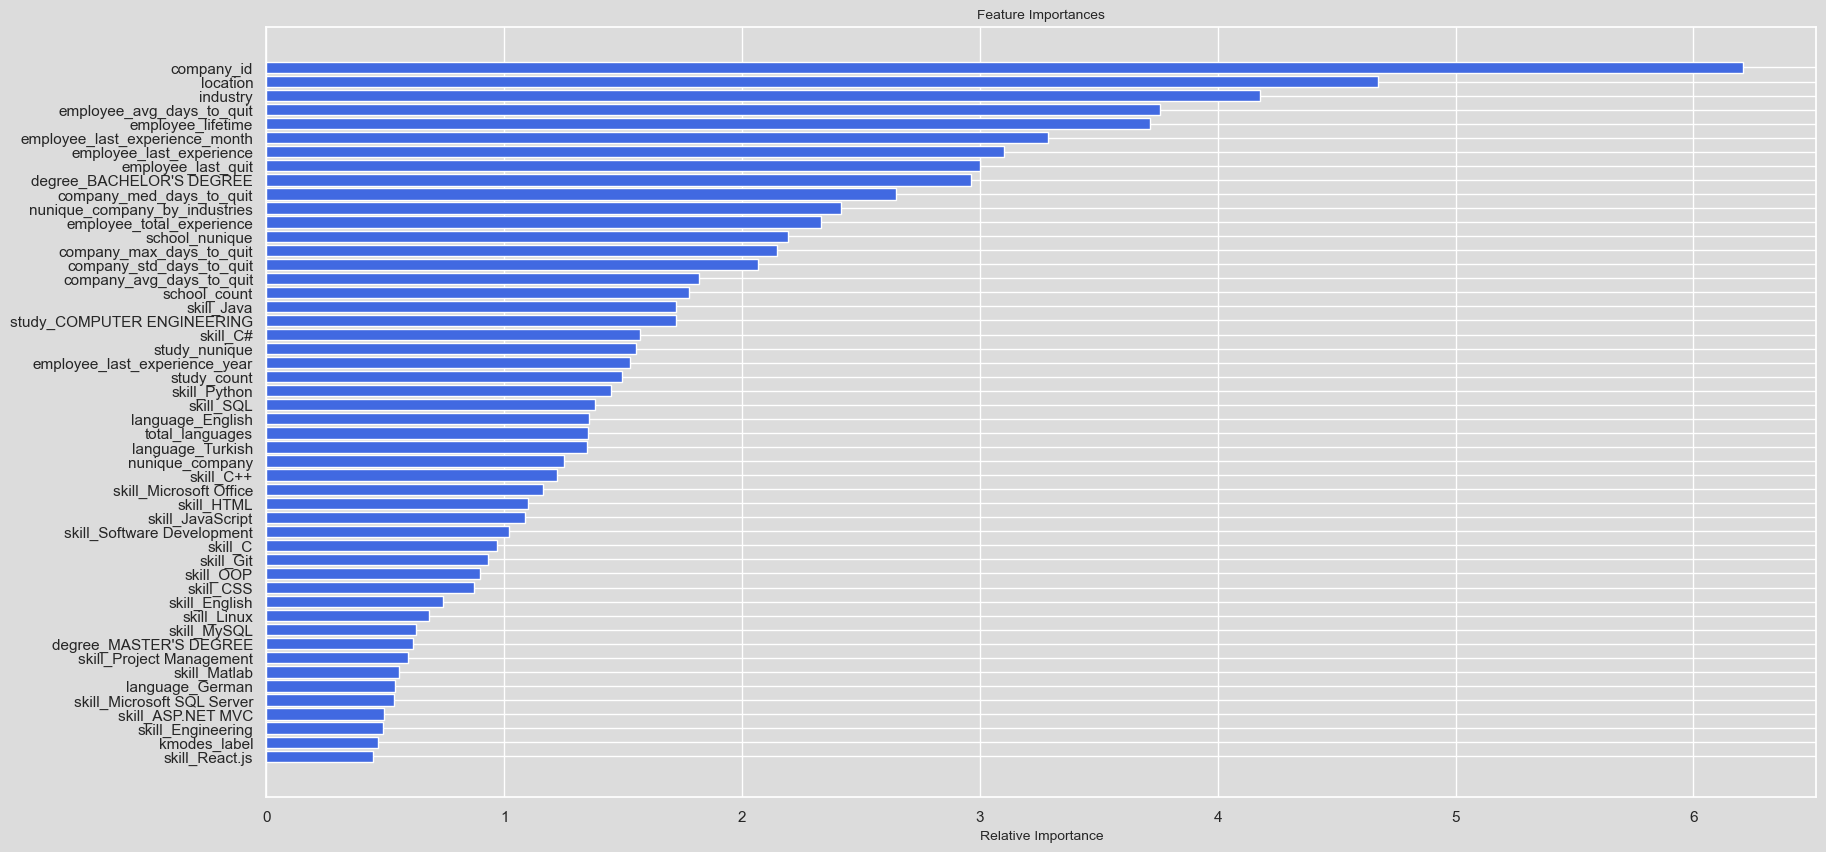

fold accuracy: 0.7837501414507185
-----------------------------------| Fold 2 |-----------------------------------
Learning rate set to 0.044197
0:	learn: 0.6526413	test: 0.6402625	best: 0.6402625 (0)	total: 231ms	remaining: 15m 25s
200:	learn: 0.8599203	test: 0.7633812	best: 0.7633812 (200)	total: 31.8s	remaining: 10m 1s
400:	learn: 0.9211896	test: 0.7789974	best: 0.7796764 (391)	total: 1m 4s	remaining: 9m 41s
600:	learn: 0.9487574	test: 0.7854476	best: 0.7856739 (584)	total: 1m 37s	remaining: 9m 10s
800:	learn: 0.9669775	test: 0.7892950	best: 0.7897477 (788)	total: 2m 9s	remaining: 8m 36s
1000:	learn: 0.9766647	test: 0.7881634	best: 0.7905398 (865)	total: 2m 41s	remaining: 8m 3s
1200:	learn: 0.9820968	test: 0.7878239	best: 0.7906529 (1186)	total: 3m 13s	remaining: 7m 30s
1400:	learn: 0.9866914	test: 0.7895213	best: 0.7906529 (1186)	total: 3m 46s	remaining: 7m
1600:	learn: 0.9895433	test: 0.7904266	best: 0.7912187 (1542)	total: 4m 18s	remaining: 6m 27s
1800:	learn: 0.9915803	test: 0.7

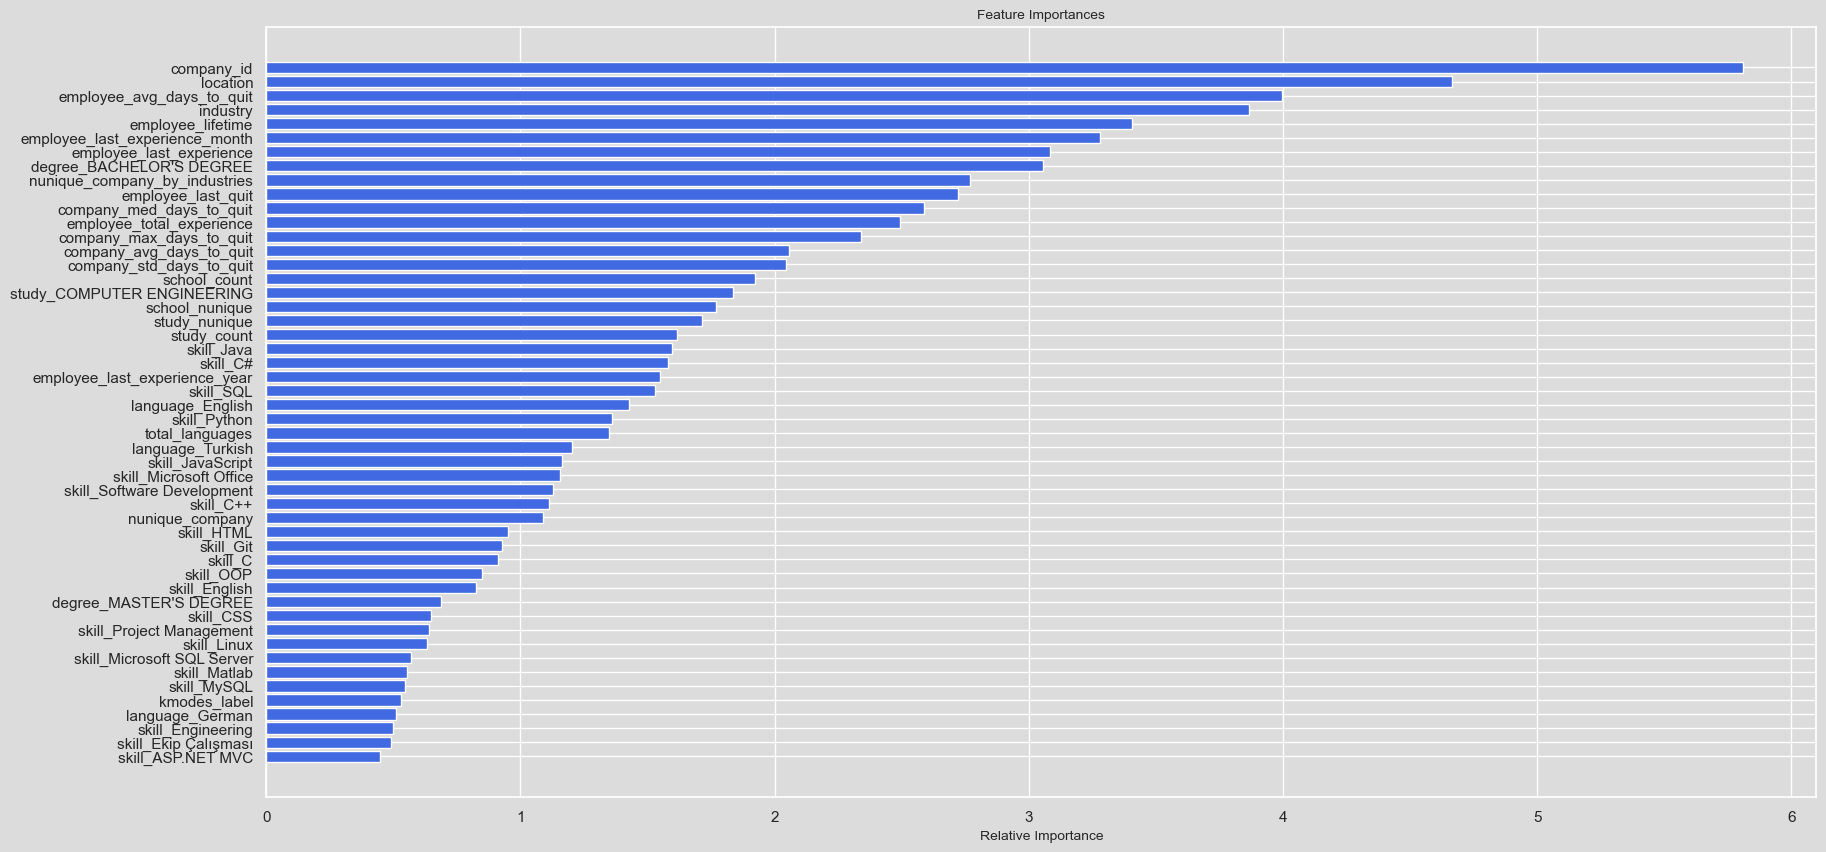

fold accuracy: 0.7925766662894648
-----------------------------------| Fold 3 |-----------------------------------
Learning rate set to 0.044197
0:	learn: 0.6532072	test: 0.6364151	best: 0.6364151 (0)	total: 237ms	remaining: 15m 46s
200:	learn: 0.8632701	test: 0.7518389	best: 0.7519520 (198)	total: 32.9s	remaining: 10m 21s
400:	learn: 0.9218686	test: 0.7672287	best: 0.7680208 (384)	total: 1m 5s	remaining: 9m 50s
600:	learn: 0.9503870	test: 0.7743578	best: 0.7749236 (598)	total: 1m 38s	remaining: 9m 15s
800:	learn: 0.9679734	test: 0.7727736	best: 0.7752631 (610)	total: 2m 11s	remaining: 8m 44s
1000:	learn: 0.9777738	test: 0.7765079	best: 0.7778658 (969)	total: 2m 43s	remaining: 8m 9s
1200:	learn: 0.9831153	test: 0.7774131	best: 0.7787711 (1170)	total: 3m 16s	remaining: 7m 37s
1400:	learn: 0.9875515	test: 0.7797895	best: 0.7800158 (1346)	total: 3m 51s	remaining: 7m 9s
1600:	learn: 0.9897243	test: 0.7802422	best: 0.7809211 (1502)	total: 4m 23s	remaining: 6m 35s
1800:	learn: 0.9923046	test

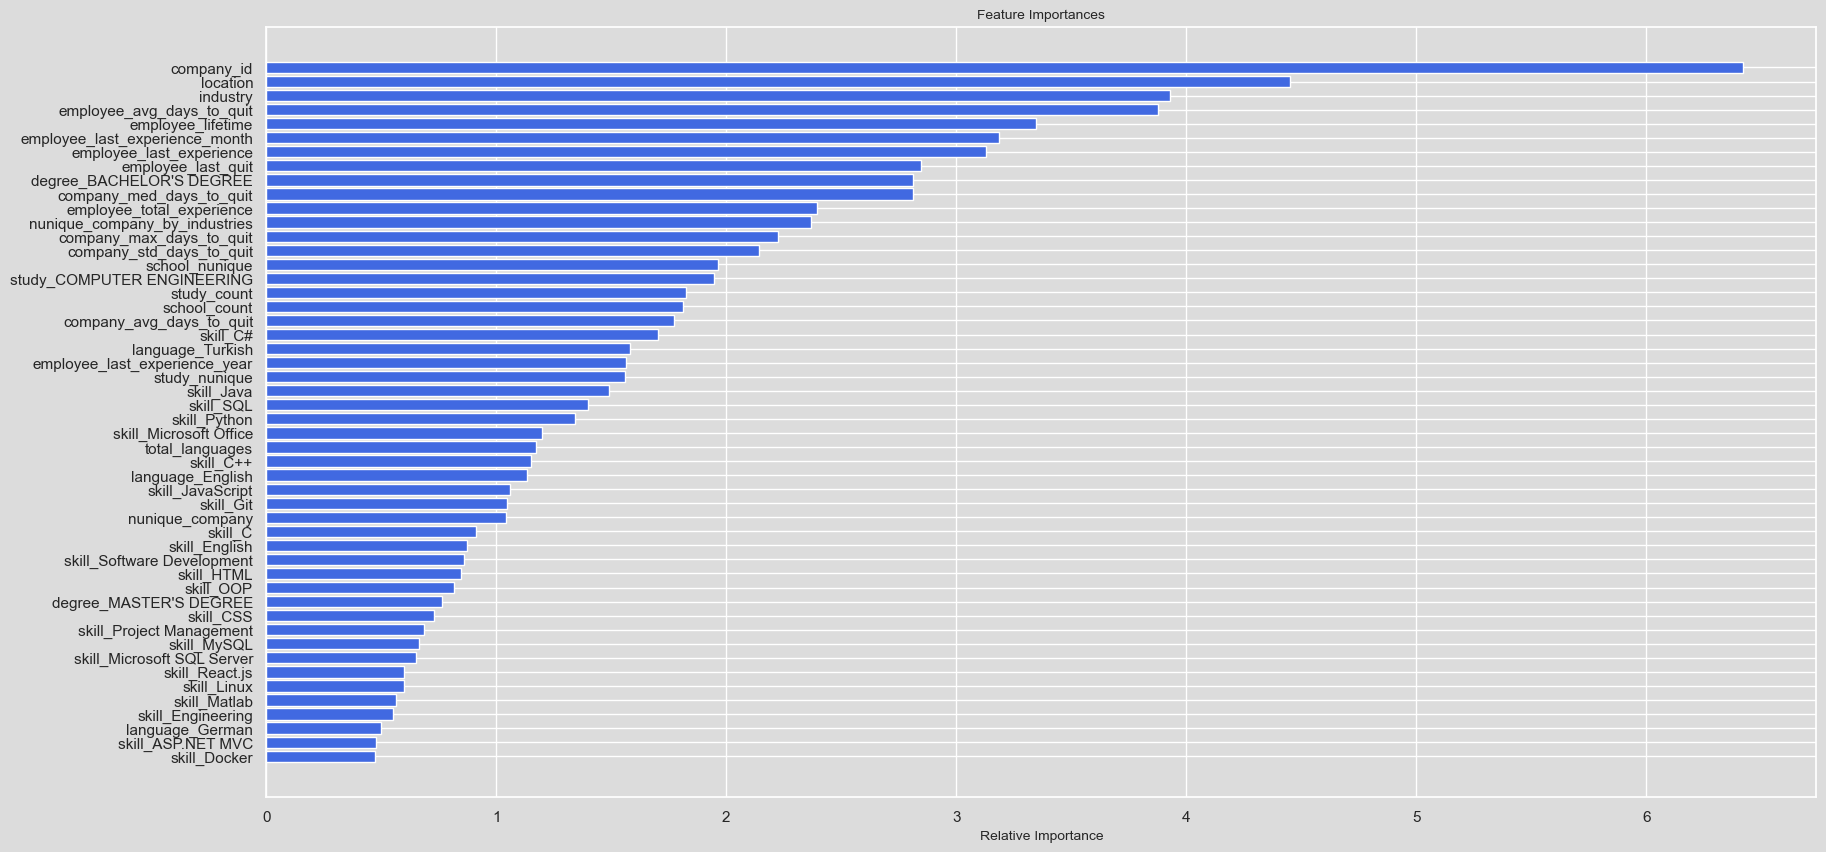

fold accuracy: 0.7809211270793256
-----------------------------------| Fold 4 |-----------------------------------
Learning rate set to 0.044197
0:	learn: 0.6128828	test: 0.6130602	best: 0.6130602 (0)	total: 47.5ms	remaining: 3m 9s
200:	learn: 0.8613494	test: 0.7518108	best: 0.7523766 (183)	total: 34.4s	remaining: 10m 49s
400:	learn: 0.9179096	test: 0.7701449	best: 0.7701449 (400)	total: 1m 8s	remaining: 10m 11s
600:	learn: 0.9490075	test: 0.7767089	best: 0.7779538 (551)	total: 1m 40s	remaining: 9m 30s
800:	learn: 0.9669104	test: 0.7796514	best: 0.7820281 (679)	total: 2m 15s	remaining: 8m 59s
1000:	learn: 0.9765747	test: 0.7803305	best: 0.7820281 (679)	total: 2m 49s	remaining: 8m 26s
1200:	learn: 0.9820293	test: 0.7823676	best: 0.7837257 (1075)	total: 3m 22s	remaining: 7m 51s
1400:	learn: 0.9867822	test: 0.7814622	best: 0.7837257 (1075)	total: 3m 57s	remaining: 7m 20s
1600:	learn: 0.9893624	test: 0.7821412	best: 0.7840652 (1467)	total: 4m 30s	remaining: 6m 45s
1800:	learn: 0.9915352	te

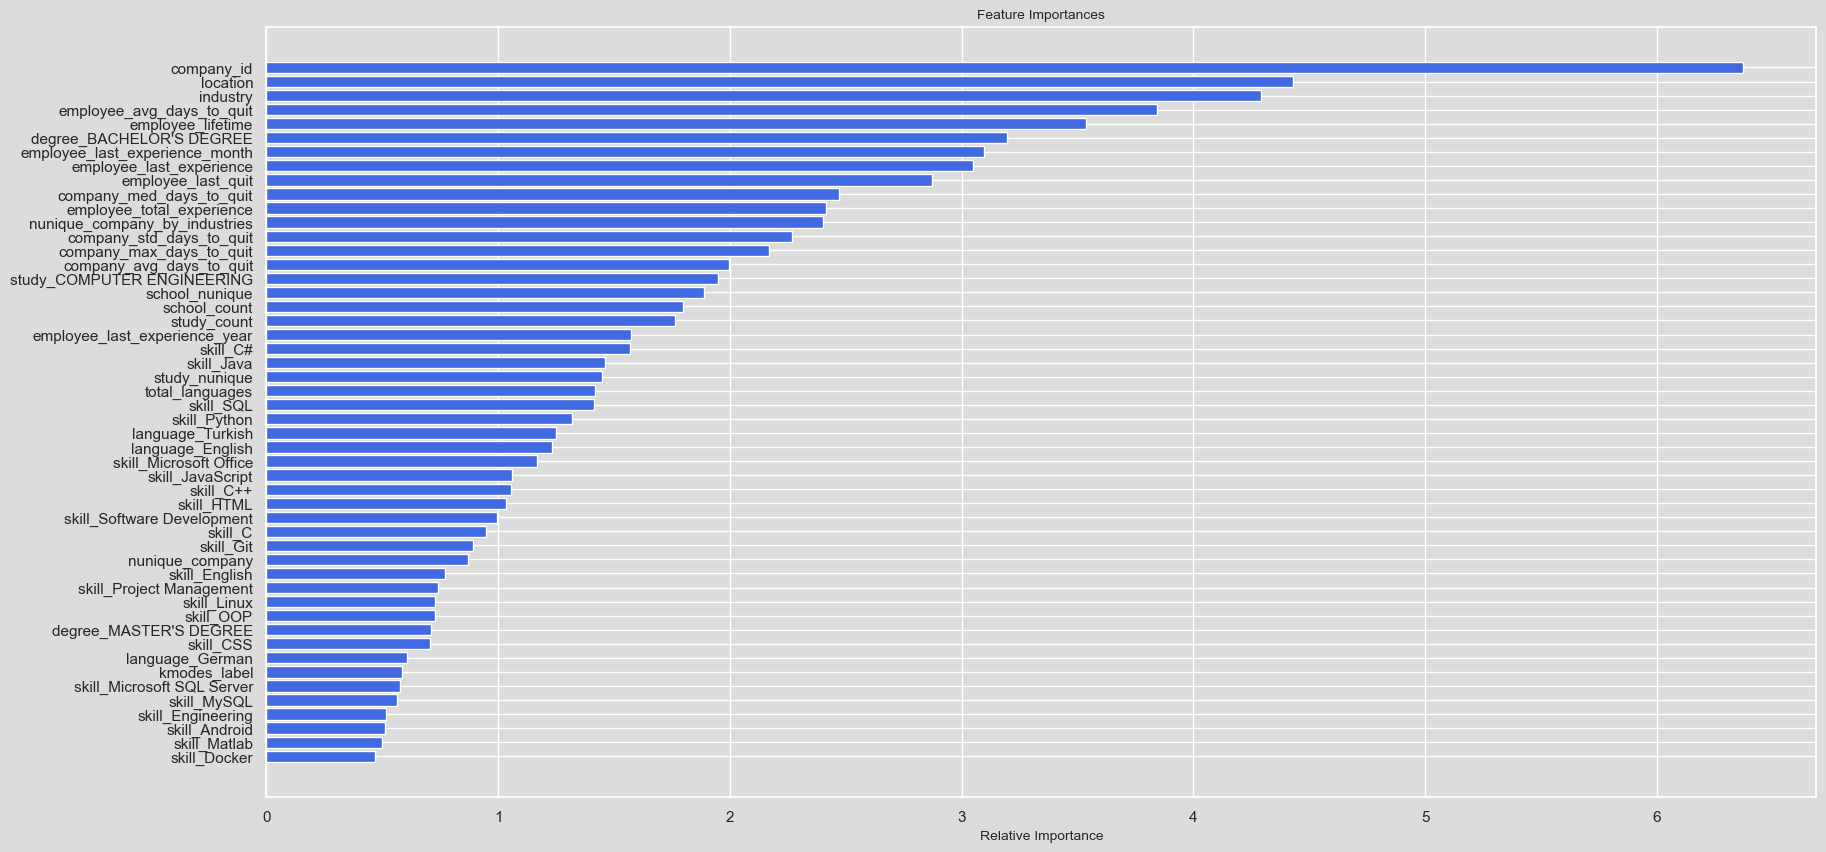

fold accuracy: 0.7856496152105025
-----------------------------------| Fold 5 |-----------------------------------
Learning rate set to 0.044197
0:	learn: 0.6128828	test: 0.6130602	best: 0.6130602 (0)	total: 25.6ms	remaining: 1m 42s
200:	learn: 0.8634995	test: 0.7558850	best: 0.7569036 (186)	total: 32.5s	remaining: 10m 14s
400:	learn: 0.9224136	test: 0.7704844	best: 0.7705976 (399)	total: 1m 5s	remaining: 9m 46s
600:	learn: 0.9516103	test: 0.7729742	best: 0.7751245 (549)	total: 1m 37s	remaining: 9m 13s
800:	learn: 0.9656882	test: 0.7768221	best: 0.7780670 (780)	total: 2m 10s	remaining: 8m 40s
1000:	learn: 0.9751941	test: 0.7789724	best: 0.7793119 (972)	total: 2m 42s	remaining: 8m 7s
1200:	learn: 0.9820972	test: 0.7795383	best: 0.7821412 (1170)	total: 3m 15s	remaining: 7m 35s
1400:	learn: 0.9861938	test: 0.7797646	best: 0.7821412 (1170)	total: 3m 48s	remaining: 7m 3s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 0.7821412404
bestIteration = 1170

Shrink model to fir

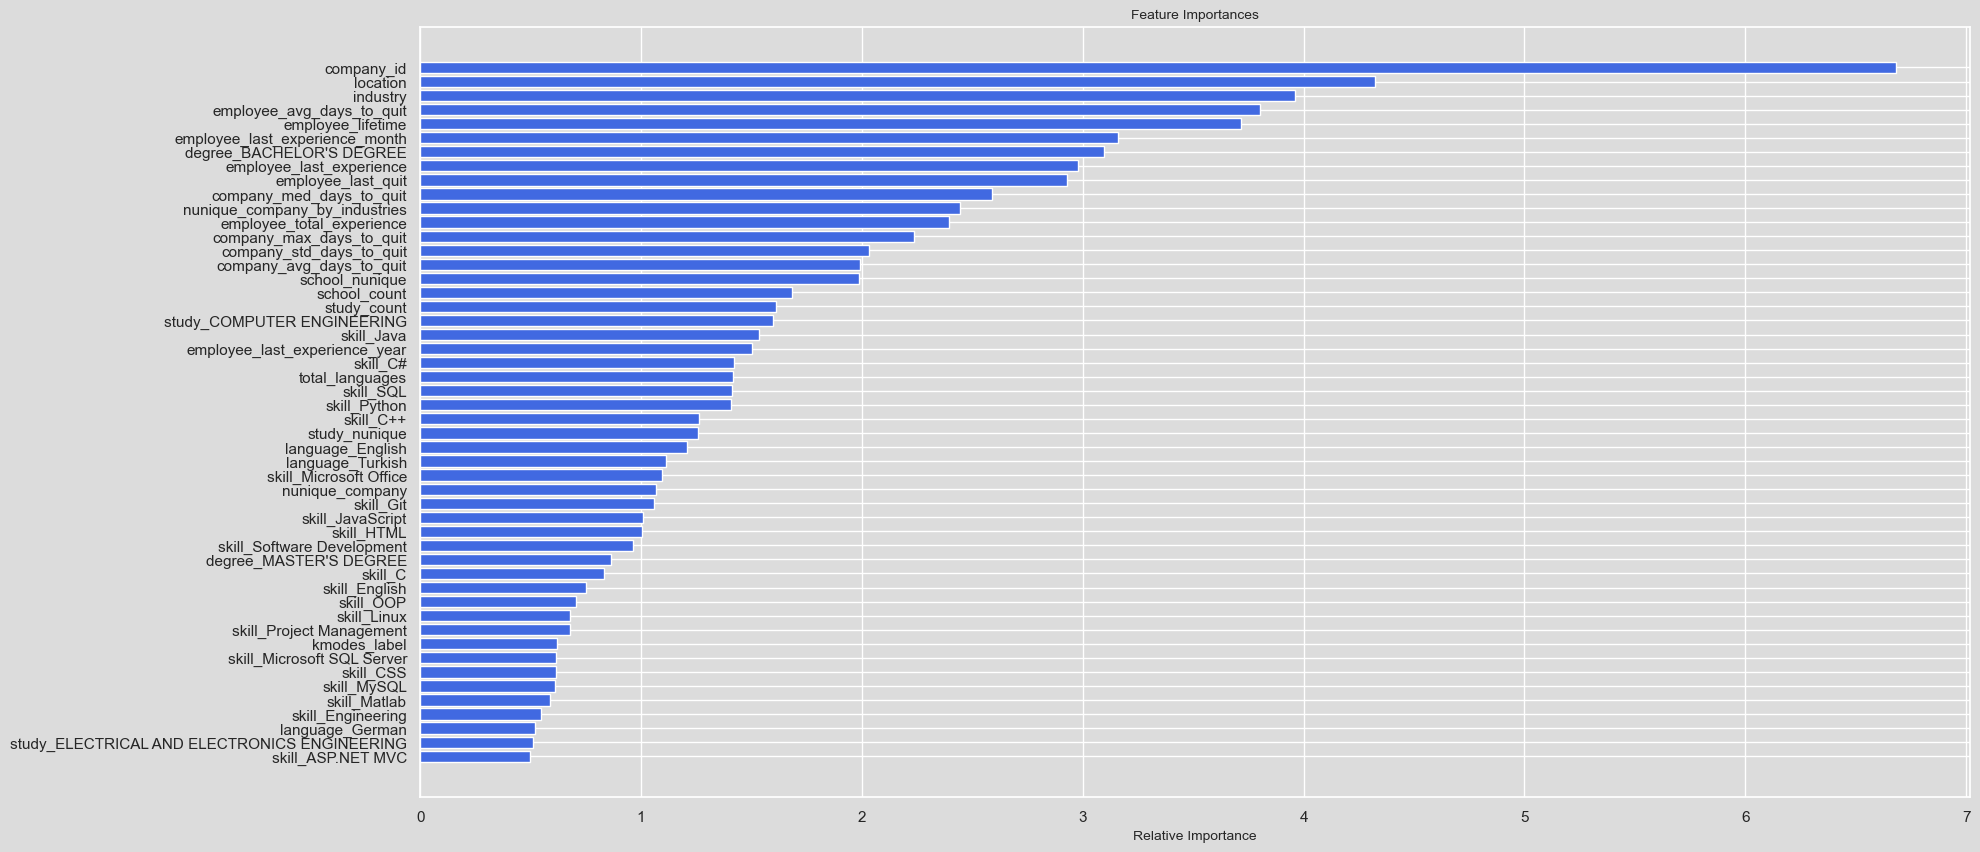

fold accuracy: 0.7821412403802626
-----------------------------------| Fold 6 |-----------------------------------
Learning rate set to 0.044197
0:	learn: 0.6129054	test: 0.6129470	best: 0.6129470 (0)	total: 38.9ms	remaining: 2m 35s
200:	learn: 0.8647670	test: 0.7519239	best: 0.7519239 (200)	total: 32.3s	remaining: 10m 10s
400:	learn: 0.9242016	test: 0.7699185	best: 0.7699185 (398)	total: 1m 4s	remaining: 9m 39s
600:	learn: 0.9525383	test: 0.7713898	best: 0.7725215 (578)	total: 1m 37s	remaining: 9m 8s
800:	learn: 0.9689700	test: 0.7769353	best: 0.7771616 (794)	total: 2m 9s	remaining: 8m 37s
1000:	learn: 0.9787475	test: 0.7786329	best: 0.7793119 (990)	total: 2m 42s	remaining: 8m 5s
1200:	learn: 0.9842473	test: 0.7794251	best: 0.7808963 (1188)	total: 3m 14s	remaining: 7m 33s
1400:	learn: 0.9884345	test: 0.7808963	best: 0.7821412 (1375)	total: 3m 47s	remaining: 7m 1s
1600:	learn: 0.9907883	test: 0.7814622	best: 0.7829335 (1507)	total: 4m 20s	remaining: 6m 29s
1800:	learn: 0.9923953	test: 

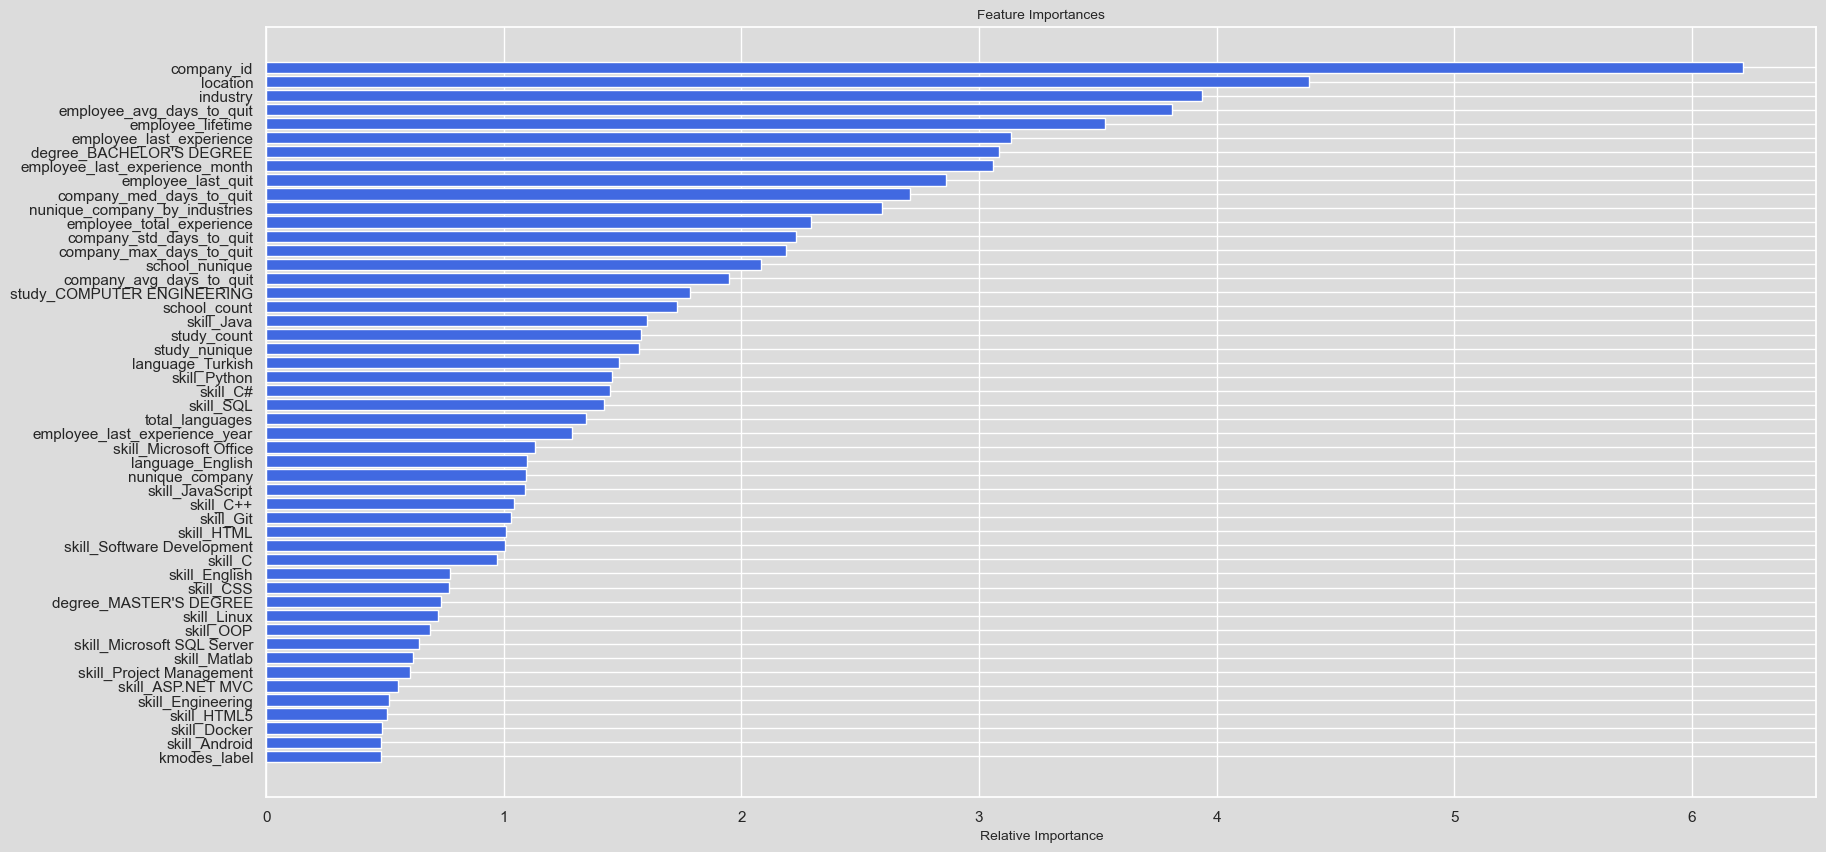

fold accuracy: 0.7829334540516071
accuracy: 0.7846621022652257


In [88]:
X = train_set.drop(columns=[target], axis=1)
y = train_set[target]
features = X.columns

X_test = test_set.drop(columns=[target], axis=1)
y_oof = np.zeros(X.shape[0])
y_pred = np.zeros(X_test.shape[0])

for idx, (train_ind, val_ind) in enumerate(kf.split(X, y)):
    print(f"| Fold {idx+1} |".center(80, "-"))
    model = CatBoostClassifier(**params)
    #model = XGBClassifier(**params)
    X_train = X.iloc[train_ind]
    y_train = y.iloc[train_ind]
    X_val = X.iloc[val_ind]
    y_val = y.iloc[val_ind]

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=400,
        verbose=200,
    )

    plot_importances(model, features)

    val_pred = model.predict(X_val)
    y_oof[val_ind] += val_pred

    test_pred = model.predict(X_test)
    y_pred += test_pred / config.n_folds

    print(f'fold accuracy: {accuracy_score(y_val, val_pred)}')
    del X_train, y_train, X_val, y_val
    gc.collect()

val_score = accuracy_score(y, y_oof)
print(f'accuracy: {val_score}')

accuracy: 0.7817008996774741

In [ ]:
sub[target] = np.where(y_pred >= 0.5, 1, 0).tolist()

sub.head()

,user_id,moved_after_2019
0,17449,0
1,33967,1
2,2110,0
3,55082,0
4,37165,0


In [ ]:
sub.to_csv(f'../submissions/submission_cat_{round(val_score, 6)}.csv', index = False)